In [1]:
import pandas as pd
import numpy as np
from scipy.special import logit
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Data preperation
test_size = 0.2
seed = 0

train_df = pd.read_csv("project_train.csv")

rows_to_remove = [68, 84, 94]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data

train_df = train_df.drop(rows_to_remove)
train_df = train_df.reset_index(drop=True)

# Transformation and scaling
vars_to_transform = ["danceability","energy","speechiness","acousticness","liveness","valence"]

train_df[vars_to_transform] = train_df[vars_to_transform].transform(logit)
train_df[vars_to_transform + ['loudness','tempo']] = preprocessing.scale(train_df[vars_to_transform + ['loudness','tempo']])

predictors_train_tree, predictors_test_tree, response_train_tree, response_test_tree = train_test_split(train_df.drop(columns=['Label']), 
                                                                                                        train_df['Label'], 
                                                                                                        test_size=test_size, 
                                                                                                        random_state=seed)

0.7920792079207921


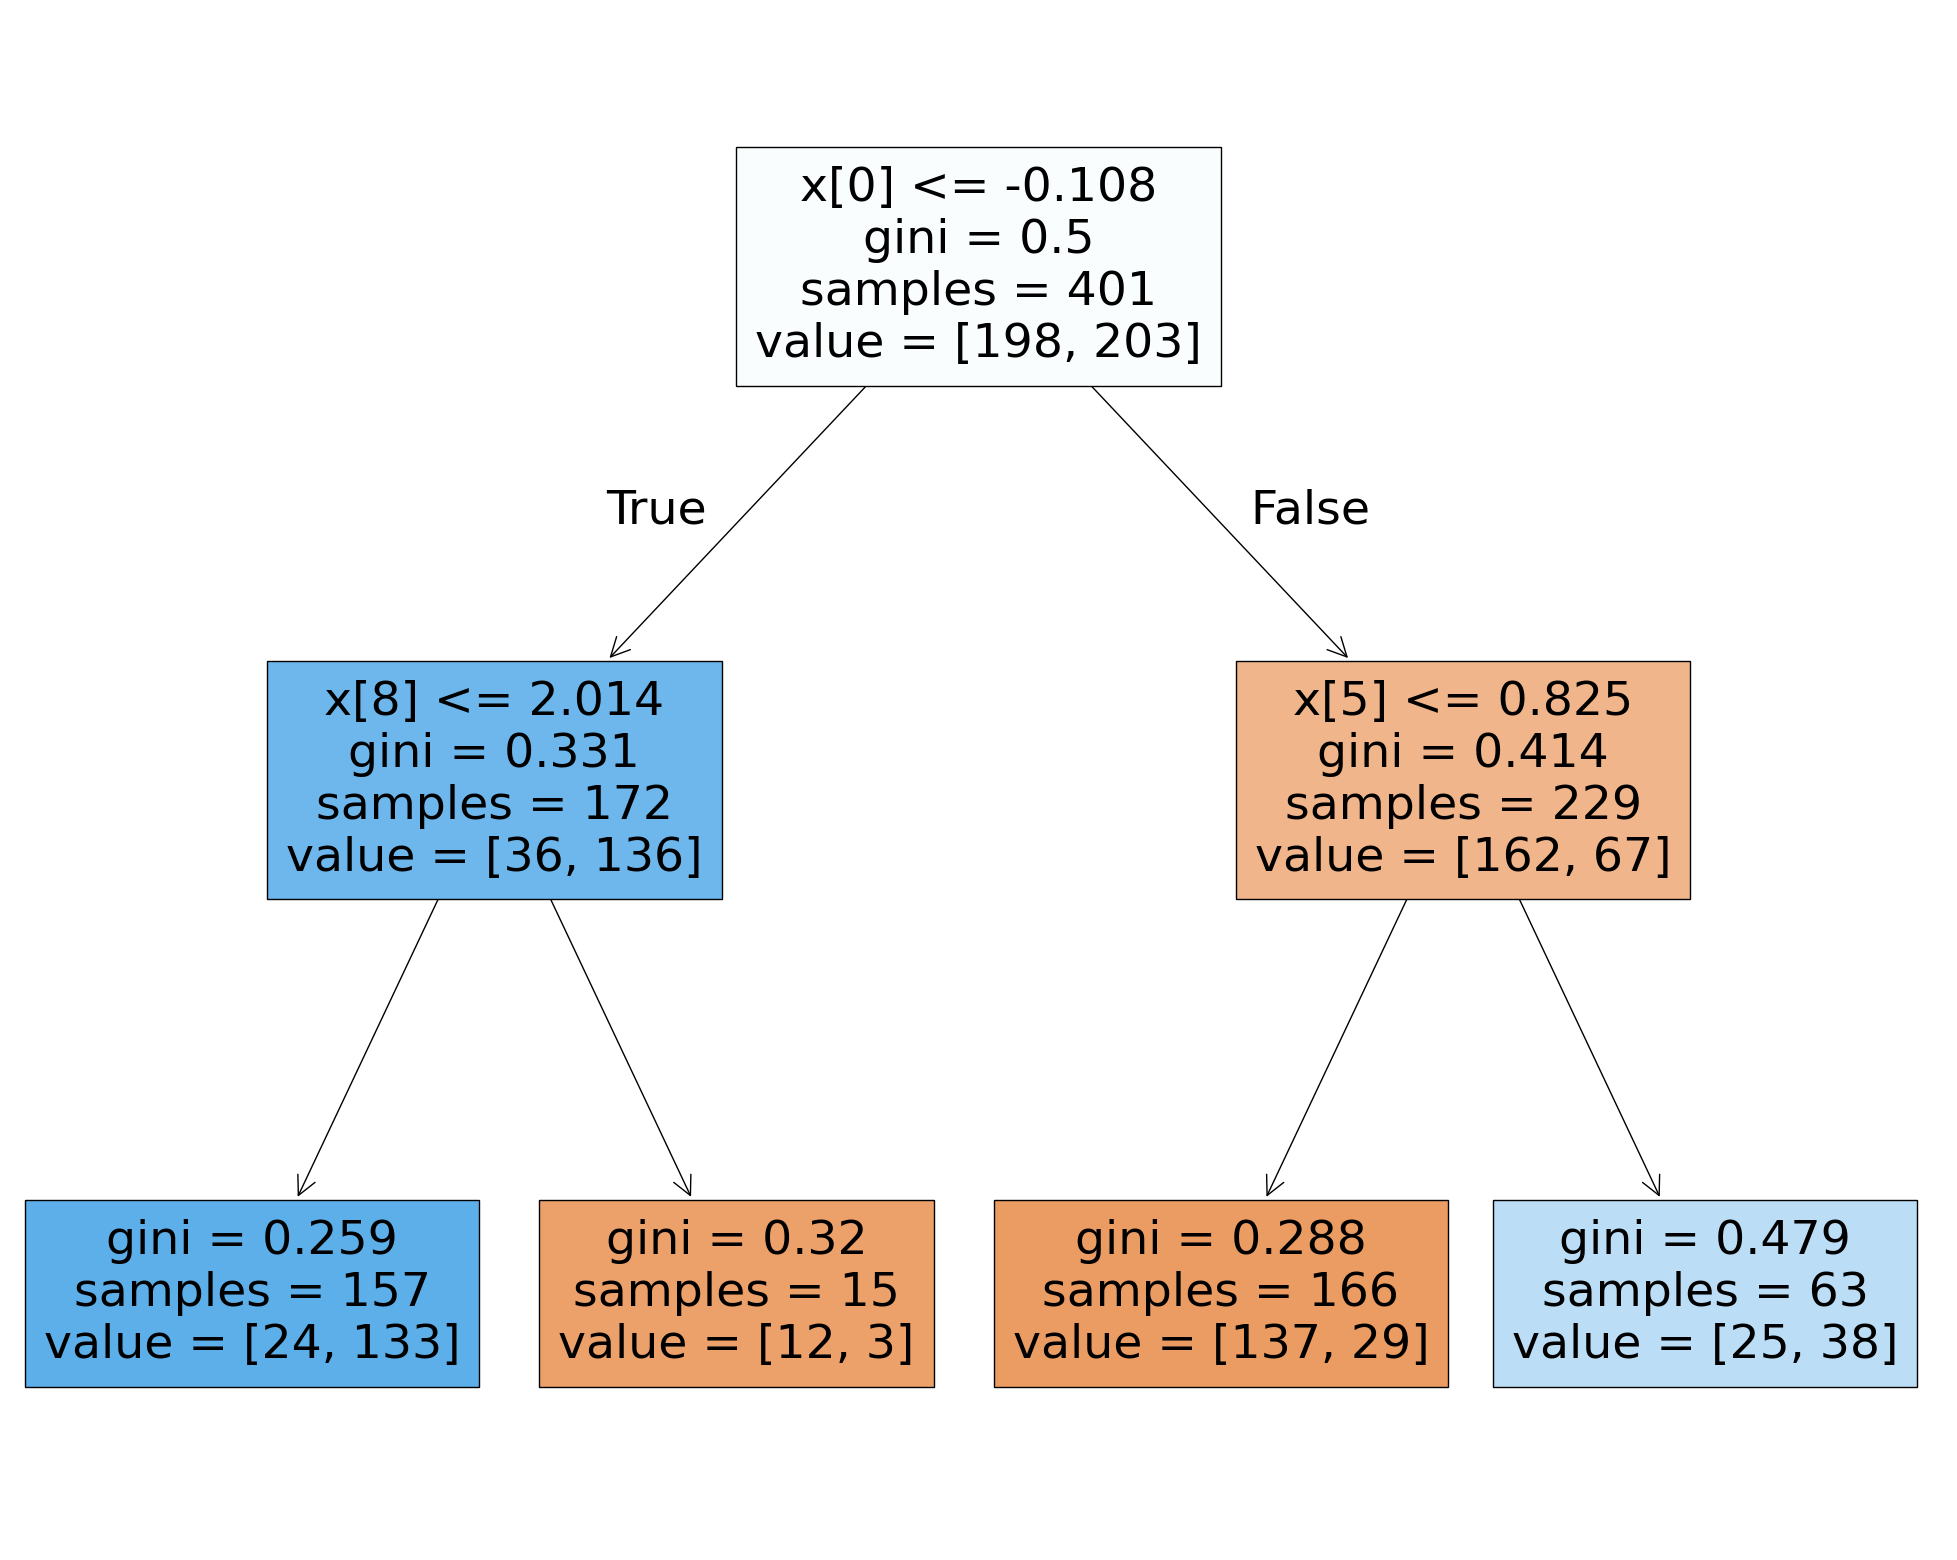

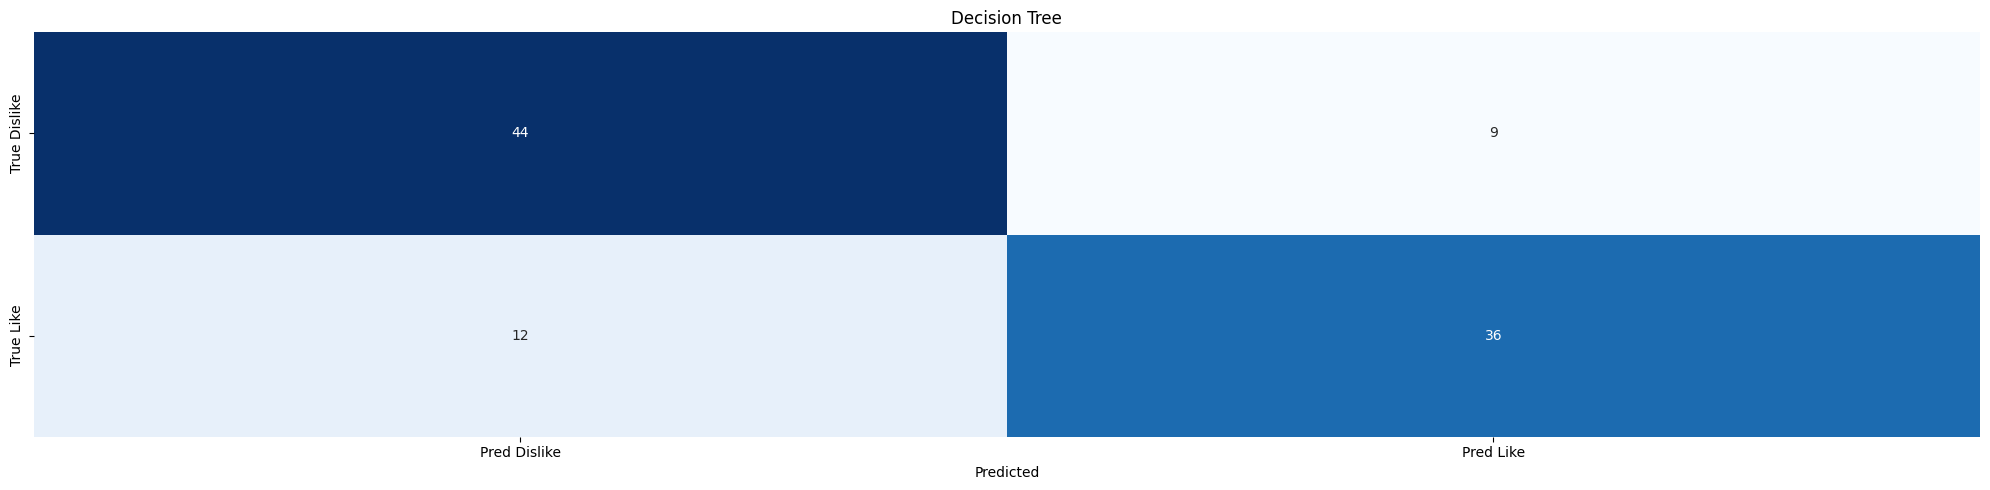

In [3]:
# Decision tree

clf_tree = tree.DecisionTreeClassifier(max_depth=2)
clf_tree = clf_tree.fit(predictors_train_tree, response_train_tree)
response_tree = clf_tree.predict(predictors_test_tree)

accuracy_tree = accuracy_score(response_test_tree, response_tree)
cm_tree = confusion_matrix(response_test_tree, response_tree)
print(accuracy_tree)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_tree,
                   filled=True)
#fig.savefig('DecisionTree.png', format='png')

fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharey=True)

sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', ax=axes, xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes.set_title('Decision Tree')
axes.set_xlabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
# Cross validation of random forest

#rf = RandomForestClassifier(random_state=0)
#
#cv_params = {'max_depth': [2,3,4,5, None], 
#             'min_samples_leaf': [1,2,3,4,5],
#            # 'min_samples_split': [2,3,4],
#            # 'max_features': [2,3,4,5,6],
#             'n_estimators': [75, 100, 125, 150, 175, 200]
#             }
#scoring = ['accuracy', 'precision', 'recall']
#
#rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='accuracy')
#rf_cv.fit(predictors_train_tree, response_train_tree)
#
#with open('rf_cv_model.pickle', 'wb') as to_write:
#    pickle.dump(rf_cv, to_write)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125, 150, 175, 200]},
             refit='accuracy', scoring=['accuracy', 'precision', 'recall'])

{'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 75}
Accuracy: 0.8514851485148515
Precision: 0.8837209302325582
Recall: 0.7916666666666666
Kappa: 0.7007702942919218


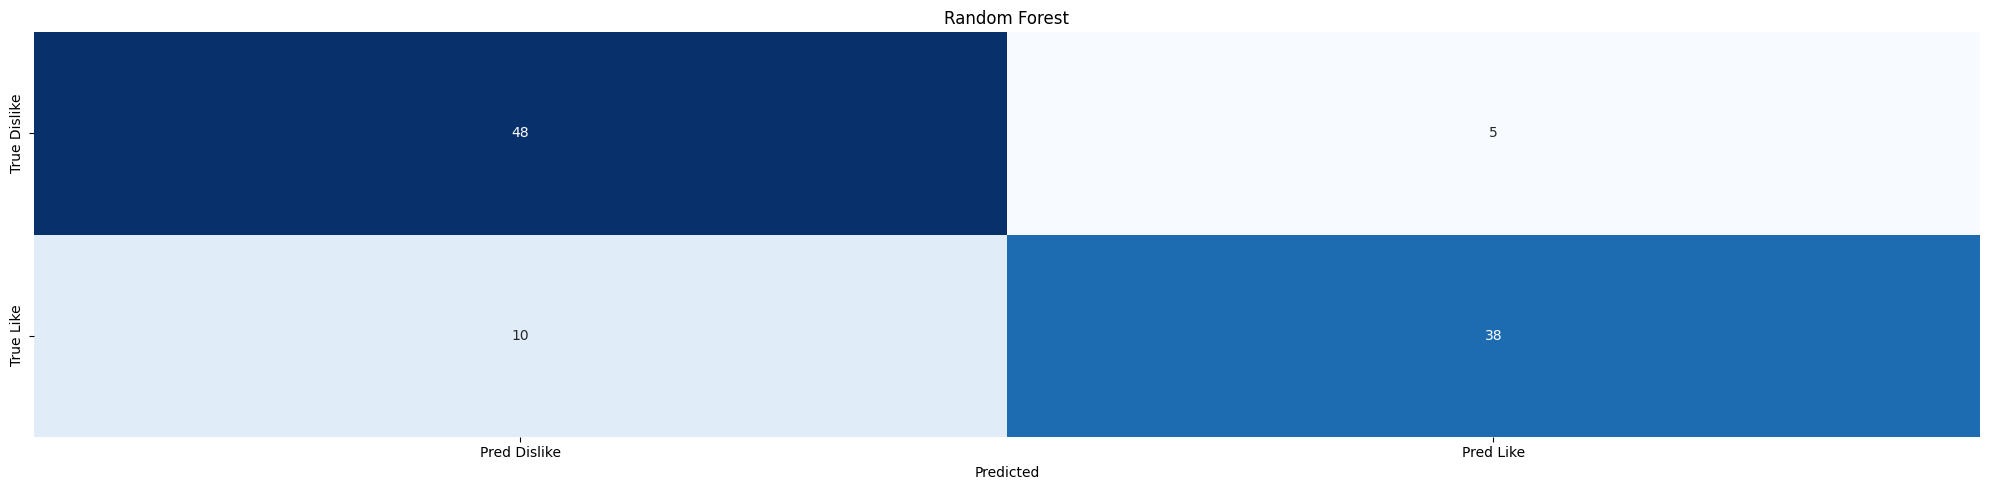

In [22]:
with open('rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

print(rf_cv.best_params_)
best_rf = rf_cv.best_estimator_
response_rf = best_rf.predict(predictors_test_tree)

accuracy_rf = accuracy_score(response_test_tree, response_rf)
precision_rf = precision_score(response_test_tree, response_rf)
recall_rf = recall_score(response_test_tree, response_rf)
kappa_rf = cohen_kappa_score(response_test_tree, response_rf)

cm_rf = confusion_matrix(response_test_tree, response_rf)
print("Accuracy: " + str(accuracy_rf))
print("Precision: " + str(precision_rf))
print("Recall: " +str(recall_rf))
print("Kappa: " +str(kappa_rf))

fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharey=True)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes, xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes.set_title('Random Forest')
axes.set_xlabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
# Cross validation gradient boosting

#gbm = GradientBoostingClassifier(random_state=0)
#
#gbm_params = {'max_depth': [1,2,3,4,5, None], 
#             'learning_rate': [0.05,0.1,0.5,1],
#            # 'min_samples_split': [2,3,4],
#            # 'max_features': [2,3,4,5,6],
#             'n_estimators': [75, 100, 125, 150, 175, 200]
#             }
#gbm_cv = GridSearchCV(gbm, gbm_params, scoring=scoring, cv=5, refit='accuracy')
#gbm_cv.fit(predictors_train_tree, response_train_tree)
#with open('gbm_cv_model.pickle', 'wb') as to_write:
#    pickle.dump(gbm_cv, to_write)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.05, 0.1, 0.5, 1],
                         'max_depth': [1, 2, 3, 4, 5, None],
                         'n_estimators': [75, 100, 125, 150, 175, 200]},
             refit='accuracy', scoring=['accuracy', 'precision', 'recall'])

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.8712871287128713
Precision: 0.9069767441860465
Recall: 0.8125
Kappa: 0.7406675883863323


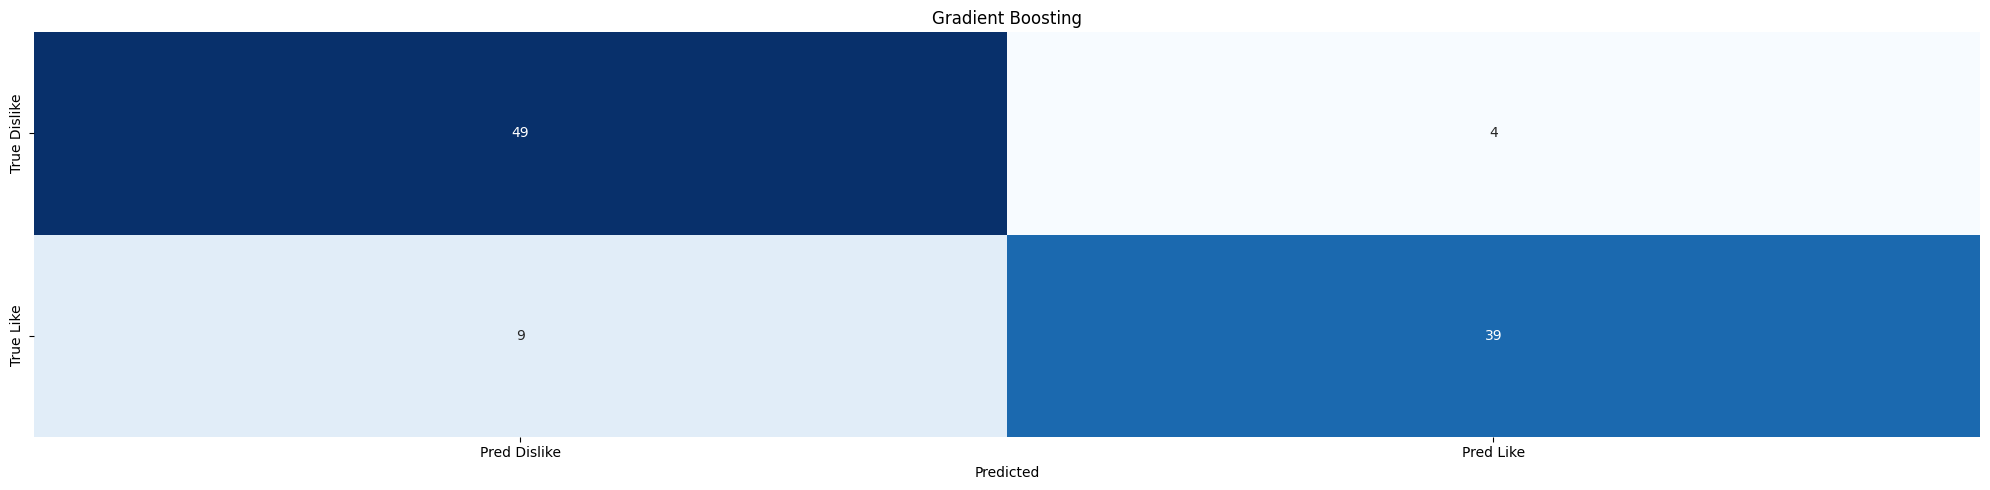

In [24]:
with open('gbm_cv_model.pickle', 'rb') as to_read:
    gbm_cv = pickle.load(to_read)

print(gbm_cv.best_params_)
best_gbm = gbm_cv.best_estimator_
response_gbm = best_gbm.predict(predictors_test_tree)

accuracy_gbm = accuracy_score(response_test_tree, response_gbm)
precision_gbm = precision_score(response_test_tree, response_gbm)
recall_gbm = recall_score(response_test_tree, response_gbm)
kappa_gbm = cohen_kappa_score(response_test_tree, response_gbm)

cm_gbm = confusion_matrix(response_test_tree, response_gbm)
print("Accuracy: " + str(accuracy_gbm))
print("Precision: " + str(precision_gbm))
print("Recall: " +str(recall_gbm))
print("Kappa: " +str(kappa_gbm))

fig, axes = plt.subplots(1, 1, figsize=(20, 5), sharey=True)

sns.heatmap(cm_gbm, annot=True, fmt='d', cmap='Blues', ax=axes, xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
axes.set_title('Gradient Boosting')
axes.set_xlabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.show()